# Dataset and DataLoader

## make_datapath_list

In [4]:
import os.path as osp
import json
import os

In [5]:
def make_datapath_list(rootpath):
    json_path = osp.join(rootpath, 'COCO.json')
    
    # Load json file
    with open(json_path) as data_file:
        data_this = json.load(data_file)
        data_json = data_this['root']
        
    # Index
    num_samples = len(data_json)
    train_indexes = []
    val_indexes = []
    for count in range(num_samples):
        if data_json[count]['isValidation'] != 0. :
            val_indexes.append(count)
        else:
            train_indexes.append(count)
            
    # File path
    train_img_list = list()
    val_img_list = list()
    
    for idx in train_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        train_img_list.append(img_path)
        
    for idx in val_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        val_img_list.append(img_path)

    # Mask data path
    train_mask_list = []
    val_mask_list = []
    
    for idx in train_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = './data/mask/train2014/mask_COCO_train2014_'+ img_idx+'.jpg'
        train_mask_list.append(anno_path)
        
    for idx in val_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = './data/mask/val2014/mask_COCO_val2014_' + img_idx + '.jpg'
        val_mask_list.append(anno_path)
        
    
    train_meta_list = list()
    val_meta_list = list()
    
    for idx in train_indexes:
        train_meta_list.append(data_json[idx])
    for idx in val_indexes:
        val_meta_list.append(data_json[idx])
        
    return train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list

train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(rootpath='./data/') 

In [6]:
val_meta_list[24]

{'dataset': 'COCO_val',
 'isValidation': 1.0,
 'img_paths': 'val2014/COCO_val2014_000000000488.jpg',
 'img_width': 640.0,
 'img_height': 406.0,
 'objpos': [233.075, 275.815],
 'image_id': 488.0,
 'bbox': [180.76, 210.3, 104.63, 131.03],
 'segment_area': 4851.846,
 'num_keypoints': 15.0,
 'joint_self': [[266.0, 231.0, 1.0],
  [0.0, 0.0, 2.0],
  [264.0, 229.0, 1.0],
  [0.0, 0.0, 2.0],
  [256.0, 231.0, 1.0],
  [261.0, 239.0, 1.0],
  [238.0, 239.0, 1.0],
  [267.0, 259.0, 1.0],
  [222.0, 262.0, 1.0],
  [272.0, 267.0, 1.0],
  [243.0, 256.0, 1.0],
  [244.0, 278.0, 1.0],
  [229.0, 279.0, 1.0],
  [269.0, 297.0, 1.0],
  [219.0, 310.0, 1.0],
  [267.0, 328.0, 1.0],
  [192.0, 329.0, 1.0]],
 'scale_provided': 0.356,
 'joint_others': [[[0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [174.0, 261.0, 1.0],
   [169.0, 275.0, 1.0],
   [155.0, 275.0, 1.0],
   [190.0, 282.0, 1.0],
   [142.0, 299.0, 1.0],
   [217.0, 285.0, 1.0],
   [133.0, 329.0, 1.0],
   [0.0, 0.0, 2.0],
   [

## Mask Data

In [10]:
import cv2
import matplotlib.pyplot as plt

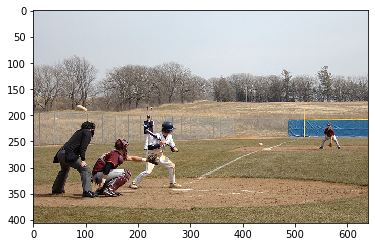

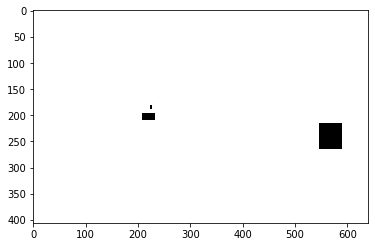

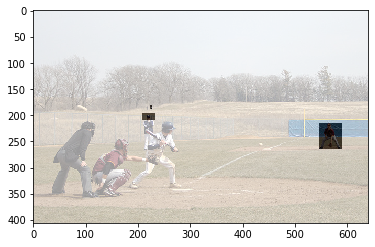

In [11]:
index = 24

# Image
img = cv2.imread(val_img_list[index])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# Mask
mask_miss = cv2.imread(val_mask_list[index])
mask_miss = cv2.cvtColor(mask_miss, cv2.COLOR_BGR2RGB)
plt.imshow(mask_miss)
plt.show()

# Image + Mask
blend_img = cv2.addWeighted(img, .4, mask_miss, .6, 0)
plt.imshow(blend_img)
plt.show()

## DataTransform

In [23]:
from utils.data_augumentation import Compose, get_anno,  add_neck, aug_scale, aug_rotate, aug_croppad, aug_flip, remove_illegal_joint, Normalize_Tensor, no_Normalize_Tensor

In [24]:
from PIL import Image

In [25]:
class DataTransform():
    def __init__(self):
        self.data_transform = {
            'train': Compose([
                get_anno(),
                add_neck(),
                aug_scale(),
                aug_rotate(),
                aug_croppad(), # Crop
                aug_flip(),
                remove_illegal_joint(),
                no_Normalize_Tensor()
            ]),
            'val':Compose([
            ])
            
        }
    
    def __call__(self, phase, meta_data, img, mask_miss):
        meta_data, img, mask_miss = self.data_transform[phase](
        meta_data, img, mask_miss)
        
        return meta_data, img, mask_miss

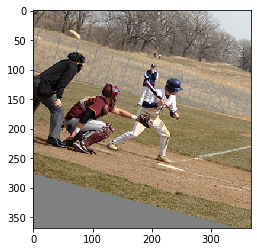

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


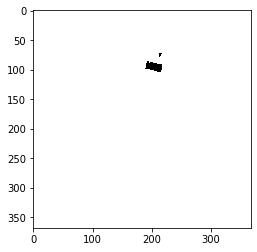

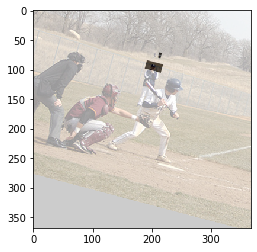

In [26]:
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meta_data = val_meta_list[index]

transform = DataTransform()
meta_data, img, mask_miss = transform('train', meta_data, img, mask_miss)

img = img.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.show()

mask_miss = mask_miss.numpy().transpose((1,2,0))
plt.imshow(mask_miss)
plt.show()

img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))
mask_miss = Image.fromarray(np.uint8((mask_miss)))
mask_miss = np.asarray(mask_miss.convert('RGB'))
blend_img = cv2.addWeighted(img, .4, mask_miss, .6, 0)
plt.imshow(blend_img)
plt.show()

In [27]:
from utils.dataloader import get_ground_truth
import torch.utils.data as data

In [30]:
class COCOkeypointsDataset(data.Dataset):
    def __init__(self, img_list, mask_list, meta_list, phase, transform):
        self.img_list = img_list
        self.mask_list = mask_list
        self.meta_list = meta_list
        self.phase = phase
        self.transform = transform
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        img, heatmaps, heat_mask, pafs, paf_mask = self.pull_item(index)
        return img, heatmaps, heat_mask, pafs, paf_mask
        
    def pull_item(self, index):
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)
        
        mask_miss = cv2.imread(self.mask_list[index])
        meta_data = self.meta_list[index]
        
        meta_data, img, mask_miss = self.transform(self.phase, meta_data, img, mask_miss)
        
        mask_miss_numpy = mask_miss.numpy().transpose((1, 2, 0))
        heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss_numpy)
        
        heat_mask = heat_mask[:, :, :, 0]
        paf_mask = paf_mask[:, :, :, 0]
        
        paf_mask = paf_mask.permute(2, 0, 1)
        heat_mask = heat_mask.permute(2, 0, 1)
        pafs = pafs.permute(2,0,1)
        heatmaps = heatmaps.permute(2, 0, 1)
        
        return img, heatmaps, heat_mask, pafs, paf_mask

In [31]:
# Intentionally give val data
train_dataset = COCOkeypointsDataset(val_img_list, val_mask_list, val_meta_list, phase='train', transform=DataTransform())
val_dataset = COCOkeypointsDataset(val_img_list, val_mask_list, val_meta_list, phase='val', transform=DataTransform())

item = train_dataset.__getitem__(0)
print(item[0].shape) # img
print(item[1].shape) # heatmaps
print(item[2].shape) # heat_mask
print(item[3].shape) # pafs
print(item[4].shape) # paf_mask

torch.Size([3, 368, 368])
torch.Size([19, 46, 46])
torch.Size([19, 46, 46])
torch.Size([38, 46, 46])
torch.Size([38, 46, 46])


## DataLoader

In [33]:
batch_size = 8
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {'train':train_dataloader, 'val':val_dataloader}

In [34]:
batch_iter = iter(dataloaders_dict['train'])
item = next(batch_iter)
print(item[0].shape) # img
print(item[1].shape) # heatmaps
print(item[2].shape) # heat_mask
print(item[3].shape) # pafs
print(item[4].shape) # paf_mask

torch.Size([8, 3, 368, 368])
torch.Size([8, 19, 46, 46])
torch.Size([8, 19, 46, 46])
torch.Size([8, 38, 46, 46])
torch.Size([8, 38, 46, 46])


# OpenPose Network

## OpenPoseNet Class

In [36]:
import torch.nn as nn

In [56]:
class OpenPoseNet(nn.Module):
    def __init__(self):
        super(OpenPoseNet, self).__init__()
        
        # Feature module
        self.model0 = OpenPose_Feature()
        
        # Stage module
        # PAFs
        self.model1_1 = make_OpenPose_block('block1_1')
        self.model2_1 = make_OpenPose_block('block2_1')
        self.model3_1 = make_OpenPose_block('block3_1')
        self.model4_1 = make_OpenPose_block('block4_1')
        self.model5_1 = make_OpenPose_block('block5_1')
        self.model6_1 = make_OpenPose_block('block6_1')
        
        # confidence heatmaps
        self.model1_2 = make_OpenPose_block('block1_2')
        self.model2_2 = make_OpenPose_block('block2_2')
        self.model3_2 = make_OpenPose_block('block3_2')
        self.model4_2 = make_OpenPose_block('block4_2')
        self.model5_2 = make_OpenPose_block('block5_2')
        self.model6_2 = make_OpenPose_block('block6_2')
        
    def forward(self, x):
        
        # Feature module
        out1 = self.model0(x)
        
        out1_1 = self.model1_1(out1)
        out1_2 = self.model1_2(out1)
        
        out2 = torch.cat([out1_1, out1_2, out1], 1) # Concat on channel 1
        out2_1 = self.model2_1(out2)
        out2_2 = self.model2_2(out2)
        
        out3 = torch.cat([out2_1, out2_2, out1], 1)
        out3_1 = self.model3_1(out3)
        out3_2 = self.model3_2(out3)
        
        out4 = torch.cat([out3_1, out3_2, out1], 1)
        out4_1 = self.model4_1(out4)
        out4_2 = self.model4_2(out4)
        
        out5 = torch.cat([out4_1, out4_2, out1], 1)
        out5_1 = self.model5_1(out5)
        out5_2 = self.model5_2(out5)
        
        out6 = torch.cat([out5_1, out5_2, out1], 1)
        out6_1 = self.model6_1(out6)
        out6_2 = self.model6_2(out6)
        
        # List for calculating loss
        saved_for_loss = []
        saved_for_loss.append(out1_1)
        saved_for_loss.append(out1_2)
        saved_for_loss.append(out2_1)
        saved_for_loss.append(out2_2)
        saved_for_loss.append(out3_1)
        saved_for_loss.append(out3_2)
        saved_for_loss.append(out4_1)
        saved_for_loss.append(out4_2)
        saved_for_loss.append(out5_1)
        saved_for_loss.append(out5_2)
        saved_for_loss.append(out6_1)
        saved_for_loss.append(out6_2)

        return (out6_1, out6_2), saved_for_loss

## Feature Module

In [57]:
import torchvision

In [58]:
class OpenPose_Feature(nn.Module):
    def __init__(self):
        super(OpenPose_Feature, self).__init__()
        
        # Use the first 10 conv layers
        vgg19 = torchvision.models.vgg19(pretrained=True)
        model = {}
        model['block0'] = vgg19.features[0:23]
        
        # Add 2 conv layers
        model['block0'].add_module('23', torch.nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1))
        model['block0'].add_module('24', torch.nn.ReLU(inplace=True))
        model['block0'].add_module('25', torch.nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1))
        model['block0'].add_module('26', torch.nn.ReLU(inplace=True))
        
        self.model = model['block0']
        
    def forward(self, x):
        outputs = self.model(x)
        return outputs
        

## Stage Module

In [59]:
import torch
from torch.nn import init

In [60]:
def make_OpenPose_block(block_name):
    #1 blocks dict
    blocks = {}
    
    # Stage1
    blocks['block1_1'] = [{'conv5_1_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_2_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_3_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_4_CPM_L1': [128, 512, 1, 1, 0]},
                          {'conv5_5_CPM_L1': [512, 38, 1, 1, 0]}]

    blocks['block1_2'] = [{'conv5_1_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_2_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_3_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_4_CPM_L2': [128, 512, 1, 1, 0]},
                          {'conv5_5_CPM_L2': [512, 19, 1, 1, 0]}]
    
    # Stage 2-6
    for i in range(2, 7):
        blocks['block%d_1' % i] = [
            {'Mconv1_stage%d_L1' % i: [185, 128, 7, 1, 3]},
            {'Mconv2_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv3_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv4_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv5_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv6_stage%d_L1' % i: [128, 128, 1, 1, 0]},
            {'Mconv7_stage%d_L1' % i: [128, 38, 1, 1, 0]}
        ]

        blocks['block%d_2' % i] = [
            {'Mconv1_stage%d_L2' % i: [185, 128, 7, 1, 3]},
            {'Mconv2_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv3_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv4_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv5_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv6_stage%d_L2' % i: [128, 128, 1, 1, 0]},
            {'Mconv7_stage%d_L2' % i: [128, 19, 1, 1, 0]}
        ]

    # 2 Configuration
    cfg_dict = blocks[block_name]
    layers = []
    for i in range(len(cfg_dict)):
        for k, v in cfg_dict[i].items():
            if 'pool' in k:
                layers += [nn.MaxPool2d(kernel_size=v[0], stride=v[1], padding=v[2])]
                
            else:
                conv2d = nn.Conv2d(in_channels=v[0], out_channels=v[1], kernel_size=v[2], stride=v[3],padding=v[4])
                layers += [conv2d, nn.ReLU(inplace=True)]
                
                
    # 3 Sequential
    net = nn.Sequential(*layers[:-1])
    
    # 4 Initialize
    def _initialize_weights_norm(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    init.constant_(m.bias, 0.0)
    
    net.apply(_initialize_weights_norm)
    
    return net

In [ ]:
net = OpenPoseNet()
net.train()

batch_size=2
dummy_img = torch.rand(batch_size, 3, 368, 368)

outputs=net(dummy_img)
print(outputs)

# Train OpenPose

## DataLoader and Network Instances

In [62]:
from utils.dataloader import make_datapath_list, DataTransform, COCOkeypointsDataset
from utils.openpose_net import OpenPoseNet

In [72]:
train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(rootpath='./data/')

train_dataset = COCOkeypointsDataset(val_img_list, val_mask_list, val_meta_list, phase='train', transform=DataTransform())

batch_size=32
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dataloaders_dict = {'train': train_dataloader, 'val':None}

net = OpenPoseNet()

## Loss Function Class

In [73]:
import torch.nn.functional as F

In [65]:
class OpenPoseLoss(nn.Module):
    def __init__(self):
        super(OpenPoseLoss, self).__init__()
        
    def forward(self, saved_for_loss, heatmap_target, heat_mask, paf_target, paf_mask):
        """
        paf_mask: 0 if mask, 1 otherwise
        """
        total_loss = 0
        for j in range(6):
            # PAFs
            pred1 = saved_for_loss[2*j] * paf_mask
            gt1 = paf_target.float() * paf_mask
            
            # heatmaps
            pred2 = saved_for_loss[2*j + 1]*heat_mask
            gt2 = heatmap_target.float()*heat_mask
            
            total_loss += F.mse_loss(pred1, gt1, reduction='mean') + F.mse_loss(pred2, gt2, reduction='mean')
            
        return total_loss

In [66]:
criterion = OpenPoseLoss()

## Optimizer

In [67]:
from torch import optim

In [74]:
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=.9,weight_decay=.0001)

## Train

In [75]:
import time

In [76]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    net.to(device)
    torch.backends.cudnn.benchmark=True
    
    num_train_imgs = len(dataloaders_dict['train'].dataset)
    batch_size = dataloaders_dict['train'].batch_size
    
    iteration = 1
    for epoch in range(num_epochs):
        
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss =0.
        epoch_val_loss=0.
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
                optimizer.zero_grad()
                
            else:
                continue
                #net.eval()
                
            for imges, heatmap_target, heat_mask, paf_target, paf_mask in dataloaders_dict[phase]:
                if imges.size()[0] == 1:
                    continue
                    
                imges = imges.to(device)
                heatmap_target = heatmap_target.to(device)
                heat_mask = heat_mask.to(device)
                paf_target = paf_target.to(device)
                paf_mask = paf_mask.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    _, saved_for_loss = net(imges)
                    
                    loss = criterion(saved_for_loss, heatmap_target, heat_mask, paf_target, paf_mask)
                    
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                    
                        if (iteration % 10== 0):
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('Iteration {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(iteration, loss.item()/batch_size, duration))
                            t_iter_start = time.time()
                            
                            epoch_train_loss += loss.item()
                            iteration += 1
                            
                t_epoch_finish = time.time()
                print('epoch {} || Epoch_TRAIN_Loss:{:.4f} || Epoch_VAL_Loss:{:.4f}'.format(epoch+1, epoch_train_loss/num_train_imgs, 0))
                print('timer: {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
                t_epoch_start = time.time()
                
            torch.save(net.state_dict(), 'weights/openpose_net_'+str(epoch+1) + '.pth')